# Part 2 - Indexing and Evaluation

Group Members:


*   Guillem Gauchia Torres - 240215 - u186410
*   Àlex Herrero Díaz - 240799 - u186402
*   Adrià Julià Parada - 242195 - u188319



# Document Pre-process

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


#### Load Python Packages

In [ ]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [ ]:
from collections import defaultdict
from array import array
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
import nltk
from nltk.tokenize import TweetTokenizer
import math
import csv
import numpy as np
import collections
import json
import string
import re
from numpy import linalg as la

#### Load Data

In [ ]:
def split_hashtag_words(text):
  tokens = re.findall(r'\w+|#\w+', text)

  result_tokens = []

  for token in tokens:
      if token.startswith('#'):
          # Remove the '#' symbol and split the hashtag into words by uppercase letters
          hashtag = token[1:]
          hashtag_words = re.findall(r'[A-Z][a-z]*', hashtag)

          # Check if all words in the hashtag are in uppercase, then treat it as a single word
          if all(word.isupper() for word in hashtag_words):
              result_tokens.append(hashtag)
          else:
              result_tokens.extend(hashtag_words)
      else:
          result_tokens.append(token)

  return result_tokens

In [ ]:
def build_terms(line):
    """
    Preprocess the text by removing stop words, stemming,
    transforming to lowercase, and returning the tokens of the text.

    Arguments:
    line -- string (text) to be preprocessed

    Returns:
    terms -- a list of tokens corresponding to the input text after preprocessing
    """
    # Remove URLs
    line = re.sub(r'http\S+', '', line)

    temp_terms = split_hashtag_words(line)
    line = " ".join(temp_terms)

    stemmer = PorterStemmer()
    stop_words = set(stopwords.words("english"))

    # Transform to lowercase
    line = line.lower()

    # Remove punctuation, emojis, symbols, numbers, and strings starting with '#' and '@'
    line = re.sub(r'@\w+', '', line)
    line = re.sub(r'#\w+', '', line)
    line = re.sub(r'[^\w\s]', '', line)
    line = re.sub(r'[\d]', '', line)

    # Tokenize the text to get a list of terms
    # Initialize the TweetTokenizer
    tokenizer = TweetTokenizer()

    # Tokenize the tweet into words
    terms = split_hashtag_words(line)

    # Remove stopwords and perform stemming
    terms = [stemmer.stem(word) for word in terms if word not in stop_words]

    # Join the words back into a sentence
    line = " ".join(terms)

    return terms, line

# Example usage
text_example = "Sample text with #RussianUkraineWar #UN and https://example.com. 😊"
terms_example, text = build_terms(text_example)
print("Original text:", text_example)
print("Preprocessed terms: ", terms_example)
print("Processed line: ", text)

Original text: Sample text with #RussianUkraineWar #UN and https://example.com. 😊
Preprocessed terms:  ['sampl', 'text', 'russian', 'ukrain', 'war', 'un']
Processed line:  sampl text russian ukrain war un


# Create Index Data

In [ ]:
def get_data_ids(file_path):
  id_to_doc = defaultdict(list)

  with open(file_path, 'r') as file:
    csv_reader = csv.reader(file, delimiter='\t')

    for row in csv_reader:
      id_to_doc[row[1]] = row[0]
  return id_to_doc

file_path = '/content/drive/Shareddrives/RIAW/IRWA Project summary and first deliverable-20231010/IRWA_data_2023/Rus_Ukr_war_data_ids.csv'

data_ids = get_data_ids(file_path)


In [ ]:
def create_index_tfidf(filepath, num_documents):
  """
  Implement the inverted index and compute tf, df and idf

  Argument:
  filepath -- filepath to the tweet's dataset
  num_documents -- total number of documents

  Returns:
  index - the inverted index (implemented through a Python dictionary) containing terms as keys and the corresponding
  list of document these keys appears in (and the positions) as values.
  tf - normalized term frequency for each term in each document
  df - number of documents each term appear in
  idf - inverse document frequency of each term
  """
  index = defaultdict(list)
  tf = defaultdict(list)  #term frequencies of terms in documents (documents in the same order as in the main index)
  df = defaultdict(int)  #document frequencies of terms in the corpus
  title_index = defaultdict(str)
  idf = defaultdict(float)

  # Base URL for tweets
  base_tweet_url = "https://twitter.com/twitter_username/status/"

  # Read the JSON file line by line and process each tweet
  with open(file_path, 'r') as file:
      for line in file:
        # Read data
        tweet_data = json.loads(line)
        created_at = tweet_data['created_at']
        full_text = tweet_data['full_text']
        hashtags = [hashtag['text'] for hashtag in tweet_data['entities']['hashtags']]
        tweet_id_str = tweet_data['id_str']  # Tweet ID to construct tweet URL
        tweet_id = tweet_data['id']
        likes = tweet_data['favorite_count']
        retweets = tweet_data['retweet_count']

        # Construct the tweet URL
        tweet_url = base_tweet_url + tweet_id_str

        # Store into dictionary
        dictionary['Tweet'].append(full_text)
        dictionary['Id'].append(tweet_data['id'])
        dictionary['Date'].append(created_at)
        dictionary['Hashtags'].append(hashtags)
        dictionary['Likes'].append(int(likes))
        dictionary['Retweets'].append(int(retweets))
        dictionary['Url'].append(tweet_url)
        dictionary['Doc'].append(data_ids[tweet_id_str])

        # Create index
        terms, line = build_terms(full_text)
        dictionary['Tokens'].append(terms)
        dictionary['ProcessedTweet'].append(line)


        title_index[data_ids[tweet_id_str]] = full_text

        # Create the index for the current tweet
        current_tweet_index = {}

        for position, term in enumerate(terms): # terms contains page_title + page_text. Loop over all terms
          try:
              # if the term is already in the index for the current page (current_page_index)
              # append the position to the corresponding list
              current_tweet_index[term][1].append(position)
          except:
              # Add the new term as dict key and initialize the array of positions and add the position
              current_tweet_index[term]=[data_ids[tweet_id_str], array('I',[position])] #'I' indicates unsigned int (int in Python)

        # normalize term frequencies
        # Compute the denominator to normalize term frequencies (formula 2 above)
        # norm is the same for all terms of a document.
        norm = 0
        for term, posting in current_tweet_index.items():
            # posting will contain the list of positions for current term in current document.
            # posting ==> [current_doc, [list of positions]]
            # you can use it to infer the frequency of current term.
            norm += len(posting[1]) ** 2
        norm = math.sqrt(norm)

        #calculate the tf(dividing the term frequency by the above computed norm) and df weights
        for term, posting in current_tweet_index.items():
            # append the tf for current term (tf = term frequency in current doc/norm)
            tf[term].append(np.round(len(posting[1]) / norm, 4)) ## SEE formula (1) above
            #increment the document frequency of current term (number of documents containing the current term)
            df[term] += 1 # increment DF for current term

        #merge the current page index with the main index
        for term_page, posting_page in current_tweet_index.items():
            index[term_page].append(posting_page)

        # Compute IDF following the formula (3) above. HINT: use np.log
        for term in df:
            idf[term] = np.round(np.log(float(num_documents / df[term])), 4)

  return index, tf, df, idf, title_index


In [ ]:
import time

file_path = '/content/drive/Shareddrives/RIAW/IRWA Project summary and first deliverable-20231010/IRWA_data_2023/Rus_Ukr_war_data.json'
dictionary = defaultdict(list)

start_time = time.time()
num_documents = 4000 # Total number of tweets
index, tf, df, idf, title_index = create_index_tfidf(file_path, num_documents)
print("Total time to create the TD-IDF index: {} seconds" .format(np.round(time.time() - start_time, 2)))

Total time to create the TD-IDF index: 232.6 seconds


In [ ]:
# Print the modified inverted index
print('Inverted Index:')
for term, postings in index.items():
    doc_list = [doc for doc, _ in postings]
    print(f'{term}: {doc_list}')

Se han truncado las últimas 5000 líneas del flujo de salida.
detain: ['doc_539', 'doc_1410', 'doc_1582', 'doc_2337', 'doc_2430', 'doc_2791', 'doc_2842', 'doc_3694', 'doc_3752', 'doc_3779']
seiz: ['doc_539', 'doc_2163', 'doc_2264', 'doc_2273', 'doc_2396', 'doc_2459', 'doc_2831', 'doc_2951', 'doc_3271', 'doc_3709', 'doc_3768']
notori: ['doc_540', 'doc_1685']
nd: ['doc_540', 'doc_780', 'doc_972', 'doc_1194', 'doc_1420', 'doc_2356', 'doc_2615', 'doc_3595', 'doc_3864']
motor: ['doc_540', 'doc_1194', 'doc_1837', 'doc_2712']
regiment: ['doc_540', 'doc_1194', 'doc_1837', 'doc_2119', 'doc_2551', 'doc_3013', 'doc_3140', 'doc_3233', 'doc_3285', 'doc_3907']
nearli: ['doc_540', 'doc_617', 'doc_890', 'doc_2715', 'doc_3422', 'doc_3621']
annihil: ['doc_540', 'doc_1977', 'doc_3269', 'doc_3629']
approv: ['doc_541', 'doc_1397', 'doc_1537', 'doc_1605', 'doc_1646', 'doc_2130', 'doc_2489', 'doc_2668']
rate: ['doc_541', 'doc_954', 'doc_995', 'doc_1762', 'doc_1827', 'doc_2039', 'doc_2335', 'doc_2854', 'doc_32

In [ ]:
print('Tweet Id Index:')
for tweet_id, tweet_text in title_index.items():
    print(f'{tweet_id}: {tweet_text}')

Se han truncado las últimas 5000 líneas del flujo de salida.
doc_2459: The #UkrainianArmy seized a fully operational and armed #Russian Tiger armored vehicle near #Lyman just as the noose closes on Russian troops. 

#UkraineRussiaWar #Breaking #Ukraine #ukraineinvasion #SlavaUkraïni #bbcnews #Lyman #tvcnewsng #Kherson #AP #Africa #Russia #Chechnya https://t.co/mhevsx2KSN
doc_2460: 💙👍🏾💛ukrainian planes🇺🇦 ukrainian special forces #ukrainerussiawar #ukrainewa... https://t.co/vEkGBOJRU3 via @YouTube
doc_2461: How real are Putin’s nuclear threats in Ukraine?
#Ukraine #UkraineRussiaWar 

https://t.co/naRscaAfKr
doc_2462: 2/ Map from UK @DefenceHQ Intel https://t.co/4Ejd4cbEEW #RussianUkrainianWar #UkraineRussiaWar #Kharkiv #Donbas #Kherson #Dnipro
doc_2463: Iran’s Drones Are Cheap, Plentiful and Helping Russia in Ukraine

Loitering munitions, which can fly long distances and wait for hours before hitting a target, have brought the war back to Odesa.

https://t.co/1jVksrLhPm

#Ukraine #Ukrain

In [ ]:
print("Index results for the term 'russia': {}\n".format(index['russia']))
print("First 10 Index results for the term 'russian': \n{}".format(index['russian'][:10]))

Index results for the term 'russia': [['doc_1', array('I', [5, 15])], ['doc_2', array('I', [12])], ['doc_3', array('I', [10, 11, 16])], ['doc_4', array('I', [5, 15])], ['doc_5', array('I', [12])], ['doc_6', array('I', [15, 16, 21])], ['doc_7', array('I', [4, 8, 19])], ['doc_8', array('I', [1, 4, 7])], ['doc_9', array('I', [0, 3, 7, 8, 9, 15])], ['doc_10', array('I', [3, 8, 18])], ['doc_11', array('I', [6, 9])], ['doc_12', array('I', [20])], ['doc_14', array('I', [0, 15])], ['doc_15', array('I', [14, 20, 22])], ['doc_16', array('I', [21])], ['doc_17', array('I', [13])], ['doc_18', array('I', [23])], ['doc_19', array('I', [20, 22, 25])], ['doc_20', array('I', [8, 19])], ['doc_21', array('I', [11])], ['doc_22', array('I', [18, 23])], ['doc_23', array('I', [21])], ['doc_24', array('I', [4, 15])], ['doc_25', array('I', [9])], ['doc_26', array('I', [19])], ['doc_27', array('I', [12, 15])], ['doc_28', array('I', [1, 4, 8])], ['doc_29', array('I', [5])], ['doc_30', array('I', [15, 19])], ['doc

In [ ]:
# Example of first element from the dictionary
element = 3803
print("Tweet: {}\nId: {}\nDate: {}\nHashtags: {}\nLikes: {}\nRetweets: {}\nUrl: {}\nDoc: {}\nTokens: {}".format(dictionary['Tweet'][element],dictionary['Id'][element], dictionary['Date'][element], dictionary['Hashtags'][element], dictionary['Likes'][element], dictionary['Retweets'][element], dictionary['Url'][element], dictionary['Doc'][element], dictionary['Tokens'][element]))

Tweet: Even more, the #referendum farce is #Russia's traditional way of control-and-compliance.

As outlined in a must-read🧵by @KristoNurmis, the Kremlin's behavior in #Ukraine is linked to long traditional coercive behavior &amp; doctrine. 3/

#UkraineRussiaWar 
https://t.co/8lnL1a9R1p
Id: 1575178447483473920
Date: Wed Sep 28 17:39:41 +0000 2022
Hashtags: ['referendum', 'Russia', 'Ukraine', 'UkraineRussiaWar']
Likes: 0
Retweets: 0
Url: https://twitter.com/twitter_username/status/1575178447483473920
Doc: doc_3804
Tokens: ['even', 'referendum', 'farc', 'russia', 'tradit', 'way', 'control', 'complianc', 'outlin', 'must', 'read', 'kristonurmi', 'kremlin', 'behavior', 'ukrain', 'link', 'long', 'tradit', 'coerciv', 'behavior', 'amp', 'doctrin', 'ukrain', 'russia', 'war']


# Querying the Index

In [ ]:
#Represent the query as a weighted tf-idf vector
#Represent each document as a weighted tfidf vector
#Compute the cosine similarity score for the
#query vector and each document vector
#Rank documents with respect to the query by score
#Return the top K (e.g., K = 10) to the user
def rank_documents(terms, docs, index, idf, tf, title_index):
    """
    Perform the ranking of the results of a search based on the tf-idf weights

    Argument:
    terms -- list of query terms
    docs -- list of documents, to rank, matching the query
    index -- inverted index data structure
    idf -- inverted document frequencies
    tf -- term frequencies
    title_index -- mapping between page id and page title

    Returns:
    Print the list of ranked documents
    """

    # I'm interested only on the element of the docVector corresponding to the query terms
    # The remaining elements would become 0 when multiplied to the query_vector
    doc_vectors = defaultdict(lambda: [0] * len(terms)) # I call doc_vectors[k] for a nonexistent key k, the key-value pair (k,[0]*len(terms)) will be automatically added to the dictionary
    query_vector = [0] * len(terms)

    # compute the norm for the query tf
    query_terms_count = collections.Counter(terms)  # get the frequency of each term in the query.
    # Example: collections.Counter(["hello","hello","world"]) --> Counter({'hello': 2, 'world': 1})
    #HINT: use when computing tf for query_vector

    query_norm = la.norm(list(query_terms_count.values()))

    for termIndex, term in enumerate(terms):  #termIndex is the index of the term in the query
        if term not in index:
            continue

        # TODO: check how to vectorize the query
        # query_vector[termIndex]=idf[term]  # original
        ## Compute tf*idf(normalize TF as done with documents)
        query_vector[termIndex] = query_terms_count[term] / query_norm * idf[term]

        # Generate doc_vectors for matching docs
        for doc_index, (doc, postings) in enumerate(index[term]):
            # Example of [doc_index, (doc, postings)]
            # 0 (26, array('I', [1, 4, 12, 15, 22, 28, 32, 43, 51, 68, 333, 337]))
            # 1 (33, array('I', [26, 33, 57, 71, 87, 104, 109]))
            # term is in doc 26 in positions 1,4, .....
            # term is in doc 33 in positions 26,33, .....

            #tf[term][0] will contain the tf of the term "term" in the doc 26
            if doc in docs:
                doc_vectors[doc][termIndex] = tf[term][doc_index] * idf[term]  # TODO: check if multiply for idf

    # Calculate the score of each doc
    # compute the cosine similarity between queyVector and each docVector:
    # HINT: you can use the dot product because in case of normalized vectors it corresponds to the cosine similarity
    # see np.dot

    doc_scores = [[np.dot(curDocVec, query_vector), doc] for doc, curDocVec in doc_vectors.items()]
    doc_scores.sort(reverse=True)
    print(doc_scores)
    result_docs = [x[1] for x in doc_scores]
    #print document titles instead if document id's
    #result_docs=[ title_index[x] for x in result_docs ]
    if len(result_docs) == 0:
        print("No results found, try again")
        query = input()
        docs = search_tf_idf(query, index)
    #print ('\n'.join(result_docs), '\n')
    return result_docs, doc_scores

In [ ]:
def search_tf_idf(query, index):
    """
    output is the list of documents that contain any of the query terms.
    So, we will get the list of documents for each query term, and take the union of them.
    """
    query, _ = build_terms(query)
    docs = set()
    for term in query:
        try:
            # store in term_docs the ids of the docs that contain "term"
            term_docs = [posting[0] for posting in index[term]]

            # docs = docs Union term_docs
            docs |= set(term_docs)
        except:
            #term is not in index
            pass
    docs = list(docs)
    ranked_docs, doc_scores = rank_documents(query, docs, index, idf, tf, title_index)
    #print( ranked_docs)
    return ranked_docs, doc_scores

### First Query

In [140]:
print("Insert your query:\n")
query = input()
ranked_docs, _ = search_tf_idf(query, index)
top = 5

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - Tweet: \n{}".format(d_id, title_index[d_id]))
    print()

Insert your query:

presidents visiting Kyiv
[[6.2176473791128934, 'doc_1243'], [3.8966111920660924, 'doc_3885'], [3.820627273820804, 'doc_1314'], [3.820627273820804, 'doc_1279'], [3.7265812673773566, 'doc_2394'], [3.6670928317282754, 'doc_656'], [3.5642630121169256, 'doc_654'], [3.5576060183563425, 'doc_1443'], [3.499156850475351, 'doc_3904'], [3.499156850475351, 'doc_3903'], [3.499156850475351, 'doc_1365'], [3.3920000426935335, 'doc_3879'], [3.299627446940659, 'doc_87'], [3.2478254285870873, 'doc_2308'], [3.2240172854617253, 'doc_131'], [3.043253341003618, 'doc_1791'], [2.971166033950395, 'doc_2212'], [2.965507455796584, 'doc_3996'], [2.965507455796584, 'doc_3434'], [2.555623457987953, 'doc_2099'], [2.344952074742465, 'doc_470'], [2.2531683600054024, 'doc_3383'], [2.2531683600054024, 'doc_1474'], [2.097217269478713, 'doc_3800'], [2.097217269478713, 'doc_2494'], [2.097217269478713, 'doc_203'], [2.097217269478713, 'doc_1887'], [2.097217269478713, 'doc_1886'], [2.097217269478713, 'doc_1

### Second Query

In [141]:
print("Insert your query:\n")
query = input()
ranked_docs, _ = search_tf_idf(query, index)
top = 5

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - Tweet: \n{}".format(d_id, title_index[d_id]))
    print()

Insert your query:

countries supporting Ukraine
[[3.3345308979963786, 'doc_3951'], [3.0339158069582393, 'doc_1943'], [3.0006744764774007, 'doc_1187'], [2.9824519687789683, 'doc_3928'], [2.934256488388778, 'doc_244'], [2.8019208672532043, 'doc_3107'], [2.722682871881903, 'doc_963'], [2.5829952717943523, 'doc_3254'], [2.52219030519766, 'doc_1507'], [2.483674268719702, 'doc_1416'], [2.4629129489120727, 'doc_2635'], [2.377394124275567, 'doc_3532'], [2.3610617474865134, 'doc_150'], [2.255420176763292, 'doc_3110'], [2.183537748736972, 'doc_3755'], [2.109201072666989, 'doc_800'], [2.109201072666989, 'doc_1633'], [1.9809498842825128, 'doc_3516'], [1.9809498842825128, 'doc_3507'], [1.9586265885639131, 'doc_1597'], [1.9254015988675806, 'doc_3127'], [1.9254015988675806, 'doc_221'], [1.9066242196556795, 'doc_1780'], [1.8739387845658957, 'doc_897'], [1.8739387845658957, 'doc_685'], [1.8739387845658957, 'doc_3028'], [1.873937746203746, 'doc_1206'], [1.856104726305586, 'doc_1535'], [1.84171365967920

### Third Query

In [168]:
print("Insert your query:\n")
query = input()
ranked_docs, _ = search_tf_idf(query, index)
top = 5

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - Tweet: \n{}".format(d_id, title_index[d_id]))
    print()

Insert your query:

Tanks in Kharkiv
[[4.684973021192155, 'doc_2234'], [4.540592419981987, 'doc_1399'], [4.463449358238235, 'doc_2841'], [4.463449358238235, 'doc_2061'], [3.783179221218297, 'doc_2656'], [3.7135444172699104, 'doc_3242'], [3.644424391145305, 'doc_3336'], [3.348105494975332, 'doc_2701'], [3.155849959908366, 'doc_3068'], [3.155849959908366, 'doc_2835'], [3.071580339016723, 'doc_2189'], [2.8878915024664016, 'doc_3451'], [2.878680394648894, 'doc_226'], [2.8547517639135083, 'doc_535'], [2.8547517639135083, 'doc_1336'], [2.7335550057772138, 'doc_3481'], [2.7335550057772138, 'doc_2185'], [2.7335550057772138, 'doc_1655'], [2.6265609927350155, 'doc_29'], [2.6265609927350155, 'doc_1155'], [2.5773248097421457, 'doc_3203'], [2.5656668675312577, 'doc_257'], [2.530929175768095, 'doc_739'], [2.530929175768095, 'doc_2651'], [2.530929175768095, 'doc_223'], [2.4796690593714215, 'doc_2425'], [2.4447658555305734, 'doc_2994'], [2.4248820123988373, 'doc_1906'], [2.3671241823495093, 'doc_2858'

### Fourth Query

In [169]:
print("Insert your query:\n")
query = input()
ranked_docs, _ = search_tf_idf(query, index)
top = 5

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - Tweet: \n{}".format(d_id, title_index[d_id]))
    print()

Insert your query:

Nord Stream Pipeline
[[7.643209885440707, 'doc_3157'], [6.244881565391305, 'doc_2875'], [6.244881565391305, 'doc_1990'], [6.192262620079923, 'doc_3480'], [6.075705560359853, 'doc_1982'], [5.741765751028365, 'doc_3344'], [5.601547196718814, 'doc_1998'], [5.361982453209696, 'doc_1992'], [5.361982453209696, 'doc_1987'], [5.335950354553601, 'doc_2884'], [5.300189286586467, 'doc_3234'], [5.2542419042947754, 'doc_1996'], [5.228715580635681, 'doc_2018'], [5.174940651798153, 'doc_1986'], [5.131470505200269, 'doc_2013'], [5.1138892084698675, 'doc_3421'], [5.1138892084698675, 'doc_2908'], [5.103711556905049, 'doc_850'], [5.0688406323478326, 'doc_2881'], [4.9644569796270615, 'doc_3036'], [4.949710639108419, 'doc_2889'], [4.949710639108419, 'doc_2865'], [4.949710639108419, 'doc_1997'], [4.945904694890621, 'doc_1452'], [4.893572190044976, 'doc_2891'], [4.893572190044976, 'doc_2873'], [4.893572190044976, 'doc_1989'], [4.893572190044976, 'doc_1985'], [4.8383950878385225, 'doc_1999

### Fifth Query

In [171]:
print("Insert your query:\n")
query = input()
ranked_docs, _ = search_tf_idf(query, index)
top = 5

print("\n======================\nTop {} results out of {} for the searched query:\n".format(top, len(ranked_docs)))
for d_id in ranked_docs[:top]:
    print("doc_id= {} - Tweet: \n{}".format(d_id, title_index[d_id]))
    print()

Insert your query:

Annexation of territories by Russia
[[3.2780825301259036, 'doc_1096'], [2.9929868009087555, 'doc_32'], [2.8758383739940725, 'doc_3697'], [2.8188883506627986, 'doc_2197'], [2.736895626551931, 'doc_3999'], [2.7224050360881167, 'doc_160'], [2.6768160887310626, 'doc_823'], [2.6768160887310626, 'doc_580'], [2.6645656325912785, 'doc_382'], [2.5958393005819524, 'doc_2625'], [2.5140259758239454, 'doc_2280'], [2.5140259758239454, 'doc_1624'], [2.4512622073917796, 'doc_2533'], [2.4184428735947603, 'doc_2052'], [2.4184262983032765, 'doc_41'], [2.418409733224542, 'doc_2657'], [2.387552926127747, 'doc_16'], [2.3782401655883256, 'doc_4'], [2.3782401655883256, 'doc_1805'], [2.318087456471069, 'doc_2470'], [2.2417099943528056, 'doc_3041'], [2.2015234500783345, 'doc_3510'], [2.15200365703578, 'doc_233'], [2.115949510883075, 'doc_1489'], [2.0843432552577914, 'doc_164'], [2.073443910713449, 'doc_695'], [2.0482143122287852, 'doc_3812'], [2.0330117544545367, 'doc_1699'], [2.032991727253

# Evaluation

In [ ]:
def read_evaluation_gt(csv_file):
  sub_dict = {} # Dictionary with the elements from evaluation_gt
  # Open the CSV file for reading
  with open(csv_file, 'r', newline='') as file:
      csv_reader = csv.reader(file)
      next(csv_reader) # Skip first line of headers

      # Iterate through the lines in the CSV
      for row in csv_reader:
          doc_id, query, label = row
          if doc_id not in sub_dict:
              sub_dict[doc_id] = {
                'Q1_label': 0,
                'Q2_label': 0,
                'Q3_label': 0
            }
          sub_dict[doc_id][f'{query}_label'] = int(label)

  return sub_dict

In [ ]:
import pandas as pd

filepath = "/content/drive/Shareddrives/RIAW/IRWA Project summary and first deliverable-20231010/Evaluation_gt.csv"

result = read_evaluation_gt(filepath)

Q_dict = {}
Q_list = [[],[],[],[]]
for doc in result:
  Q_list[0].append(doc)
  Q_list[1].append(result[doc]['Q1_label'])
  Q_list[2].append(result[doc]['Q2_label'])
  Q_list[3].append(result[doc]['Q3_label'])

label_relevance = pd.DataFrame(list(zip(Q_list[0], Q_list[1], Q_list[2], Q_list[3])),
               columns =['doc_id', 'is_relevant_Q1', 'is_relevant_Q2', 'is_relevant_Q3'])

display(label_relevance.head())

,doc_id,is_relevant_Q1,is_relevant_Q2,is_relevant_Q3
0,doc_1452,0,1,1
1,doc_2908,0,1,1
2,doc_618,0,1,1
3,doc_489,0,1,1
4,doc_110,0,1,1


## Precision @ K (P@K)

In [167]:
# Predicted relevance for Query 1
query = "Tank in Kharkiv"
_, doc_scores = search_tf_idf(query, index)

# Convert the list of tuples to a dictionary
tuple_dict = {doc_id: value for value, doc_id in doc_scores}


label_relevance['predicted_relevance_Q1'] = label_relevance['doc_id'].map(tuple_dict)
label_relevance['predicted_relevance_Q1'] = label_relevance['predicted_relevance_Q1'].fillna(0.0)

# Predicted relevance for Query 2
query = "Nord Stream pipeline"
_, doc_scores = search_tf_idf(query, index)

# Convert the list of tuples to a dictionary
tuple_dict = {doc_id: value for value, doc_id in doc_scores}


label_relevance['predicted_relevance_Q2'] = label_relevance['doc_id'].map(tuple_dict)
label_relevance['predicted_relevance_Q2'] = label_relevance['predicted_relevance_Q2'].fillna(0.0)

# Predicted relevance for Query 3
query = "annexation of territories by Russia"
_, doc_scores = search_tf_idf(query, index)

# Convert the list of tuples to a dictionary
tuple_dict = {doc_id: value for value, doc_id in doc_scores}


label_relevance['predicted_relevance_Q3'] = label_relevance['doc_id'].map(tuple_dict)
label_relevance['predicted_relevance_Q3'] = label_relevance['predicted_relevance_Q3'].fillna(0.0)

display(label_relevance.head(10))

[[4.684973021192155, 'doc_2234'], [4.540592419981987, 'doc_1399'], [4.463449358238235, 'doc_2841'], [4.463449358238235, 'doc_2061'], [3.783179221218297, 'doc_2656'], [3.7135444172699104, 'doc_3242'], [3.644424391145305, 'doc_3336'], [3.348105494975332, 'doc_2701'], [3.155849959908366, 'doc_3068'], [3.155849959908366, 'doc_2835'], [3.071580339016723, 'doc_2189'], [2.8878915024664016, 'doc_3451'], [2.878680394648894, 'doc_226'], [2.8547517639135083, 'doc_535'], [2.8547517639135083, 'doc_1336'], [2.7335550057772138, 'doc_3481'], [2.7335550057772138, 'doc_2185'], [2.7335550057772138, 'doc_1655'], [2.6265609927350155, 'doc_29'], [2.6265609927350155, 'doc_1155'], [2.5773248097421457, 'doc_3203'], [2.5656668675312577, 'doc_257'], [2.530929175768095, 'doc_739'], [2.530929175768095, 'doc_2651'], [2.530929175768095, 'doc_223'], [2.4796690593714215, 'doc_2425'], [2.4447658555305734, 'doc_2994'], [2.4248820123988373, 'doc_1906'], [2.3671241823495093, 'doc_2858'], [2.3311438947777967, 'doc_2178'], 

,doc_id,is_relevant_Q1,is_relevant_Q2,is_relevant_Q3,predicted_relevance_Q1,predicted_relevance_Q2,predicted_relevance_Q3
0,doc_1452,0,1,1,0.0,4.945905,0.000018
1,doc_2908,0,1,1,0.0,5.113889,0.000019
2,doc_618,0,1,1,0.0,4.794443,0.000053
3,doc_489,0,1,1,0.0,2.988094,0.000017
4,doc_110,0,1,1,0.0,3.273101,0.000019
5,doc_3439,0,1,1,0.0,2.403367,0.000026
6,doc_3137,0,1,1,0.0,2.799881,0.000016
7,doc_3913,0,1,1,0.0,2.029107,0.000035
8,doc_2944,0,0,1,0.0,2.534592,0.000029
9,doc_2696,0,1,1,0.0,2.907431,0.000017


In [ ]:
def precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    precision @k : float

    """
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    relevant = sum(doc_score == 1)
    return float(relevant) / k

In [ ]:
# Check for query 1
k = 5
print("==> Precision@{}: {} for Question 1".format(k, precision_at_k(label_relevance['is_relevant_Q1'], label_relevance['predicted_relevance_Q1'], k)))

print("\nCheck on the dataset sorted by score:\n")
label_relevance.sort_values("predicted_relevance_Q1", ascending=False).head(k)

==> Precision@5: 0.8 for Question 1

Check on the dataset sorted by score:



,doc_id,is_relevant_Q1,is_relevant_Q2,is_relevant_Q3,predicted_relevance_Q1,predicted_relevance_Q2,predicted_relevance_Q3
31,doc_2234,1,0,0,4.684973,0.0,0.000026
32,doc_2656,1,0,0,3.783179,0.0,0.000021
37,doc_2701,1,0,0,3.348105,0.0,0.000025
40,doc_1336,0,0,0,2.854752,0.0,0.000031
34,doc_592,1,0,0,2.156594,0.0,0.000048


In [ ]:
# Check for query 2
k = 5
print("==> Precision@{}: {} for Question 2".format(k, precision_at_k(label_relevance['is_relevant_Q2'], label_relevance['predicted_relevance_Q2'], k)))

print("\nCheck on the dataset sorted by score:\n")
label_relevance.sort_values("predicted_relevance_Q2", ascending=False).head(k)

==> Precision@5: 1.0 for Question 2

Check on the dataset sorted by score:



,doc_id,is_relevant_Q1,is_relevant_Q2,is_relevant_Q3,predicted_relevance_Q1,predicted_relevance_Q2,predicted_relevance_Q3
1,doc_2908,0,1,1,0.0,5.113889,0.000019
0,doc_1452,0,1,1,0.0,4.945905,0.000018
2,doc_618,0,1,1,0.0,4.794443,0.000053
4,doc_110,0,1,1,0.0,3.273101,0.000019
20,doc_2677,0,1,0,0.0,3.029321,0.000035


In [ ]:
# Check for query 3
k = 5
print("==> Precision@{}: {} for Question 3".format(k, precision_at_k(label_relevance['is_relevant_Q3'], label_relevance['predicted_relevance_Q3'], k)))

print("\nCheck on the dataset sorted by score:\n")
label_relevance.sort_values("predicted_relevance_Q3", ascending=False).head(k)

==> Precision@5: 0.2 for Question 3

Check on the dataset sorted by score:



,doc_id,is_relevant_Q1,is_relevant_Q2,is_relevant_Q3,predicted_relevance_Q1,predicted_relevance_Q2,predicted_relevance_Q3
17,doc_3422,0,0,0,0.000000,0.000000,0.000059
41,doc_2295,0,0,0,1.700542,0.000000,0.000055
2,doc_618,0,1,1,0.000000,4.794443,0.000053
22,doc_3326,0,0,0,0.000000,0.000000,0.000053
38,doc_2956,1,0,0,0.703644,0.000000,0.000050


## Recall @ K - (R@K)

In [142]:
def recall_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : Number of documents to consider.

    Returns
    -------
    recall @k : float
    """
    order = np.argsort(y_score)[::-1]
    order_k = order[:k]  # Get the top k document indices
    doc_score_k = doc_score[order_k]  # Get the corresponding relevance labels for the top k documents

    total_relevant = np.sum(doc_score_k)
    relevant = np.sum(doc_score_k == 1.0)

    return float(relevant) / total_relevant if total_relevant > 0 else 0.0

In [172]:
# Compute recall for Queries 1 to 3
k = 5
print("==> Recall@{}: {} for Question 1".format(k, recall_at_k(label_relevance['is_relevant_Q1'], label_relevance['predicted_relevance_Q1'], k)))
print("==> Recall@{}: {} for Question 2".format(k, recall_at_k(label_relevance['is_relevant_Q2'], label_relevance['predicted_relevance_Q2'], k)))
print("==> Recall@{}: {} for Question 3".format(k, recall_at_k(label_relevance['is_relevant_Q3'], label_relevance['predicted_relevance_Q3'], k)))

==> Recall@5: 1.0 for Question 1
==> Recall@5: 1.0 for Question 2
==> Recall@5: 1.0 for Question 3


## F1-Score@K - (F1@K)

In [149]:
def f1_score_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : Number of documents to consider.

    Returns
    -------
    f1-score @k : float

    """
    precision = precision_at_k(doc_score, y_score, k)
    recall = recall_at_k(doc_score, y_score, k)
    f1 = 2 * (precision * recall) / (precision + recall) if (precision + recall) > 0 else 0.0
    return f1

In [150]:
# Check for query 1
k = 5
print("==> F1-Score@{}: {} for Question 1".format(k, f1_score_at_k(label_relevance['is_relevant_Q1'], label_relevance['predicted_relevance_Q1'], k)))
print("==> F1-Score@{}: {} for Question 2".format(k, f1_score_at_k(label_relevance['is_relevant_Q2'], label_relevance['predicted_relevance_Q2'], k)))
print("==> F1-Score@{}: {} for Question 3".format(k, f1_score_at_k(label_relevance['is_relevant_Q3'], label_relevance['predicted_relevance_Q3'], k)))

==> F1-Score@5: 0.888888888888889 for Question 1
==> F1-Score@5: 1.0 for Question 2
==> F1-Score@5: 0.33333333333333337 for Question 3


## Average Precision@K - AP@K

In [151]:
def avg_precision_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    average precision @k : float
    """
    gtp = np.sum(doc_score == 1)
    order = np.argsort(y_score)[::-1]
    doc_score = np.take(doc_score, order[:k])
    ## if all documents are not relevant
    if gtp == 0:
        return 0
    n_relevant_at_i = 0
    prec_at_i = 0
    for i in range(len(doc_score)):
        if doc_score[i] == 1:
            n_relevant_at_i += 1
            prec_at_i += n_relevant_at_i / (i + 1)
    return prec_at_i / gtp

In [177]:
# List for the average precision for each query
avg_precision = []

# Average precision@k for Question 1
k = 10
avg_precision.append(avg_precision_at_k(np.array(label_relevance["is_relevant_Q1"]), np.array(label_relevance["predicted_relevance_Q1"]), k))

print("==> Average Precision@{}: {} for Question 1".format(k, avg_precision[0]))

# Average precision@k for Question 2
k = 10
avg_precision.append(avg_precision_at_k(np.array(label_relevance["is_relevant_Q2"]), np.array(label_relevance["predicted_relevance_Q2"]), k))

print("==> Average Precision@{}: {} for Question 2".format(k, avg_precision[1]))

# Average precision@k for Question 3
k = 10
avg_precision.append(avg_precision_at_k(np.array(label_relevance["is_relevant_Q3"]), np.array(label_relevance["predicted_relevance_Q3"]), k))

print("==> Average Precision@{}: {} for Question 3".format(k, avg_precision[2]))

==> Average Precision@10: 0.716547619047619 for Question 1
==> Average Precision@10: 0.89 for Question 2
==> Average Precision@10: 0.025 for Question 3


## Mean Average Precision (mAP)

In [153]:
def map_at_k(avg_prec_list):
    """
    Parameters
    ----------
    avg_prec_list: a list with previously computed average precision for each query

    Returns
    -------
    mean average precision @ k : float
    """
    total_sum = sum(avg_prec_list)
    return total_sum/len(avg_prec_list)

In [173]:
map_k = map_at_k(avg_precision)
print("==> Mean Average Precision@{}: {} for All 3 Questions".format(k, map_k))

==> Mean Average Precision@5: 0.6694204291172254 for All 3 Questions


## Mean Reciprocal Rank (MRR)

In [155]:
def rr_at_k(doc_score, y_score, k=10):
    """
    Parameters
    ----------
    doc_score: Ground truth (true relevance labels).
    y_score: Predicted scores.
    k : number of doc to consider.

    Returns
    -------
    Reciprocal Rank for qurrent query
    """

    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[
                             :k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    if np.sum(doc_score) == 0:  # if there are not relevant doument return 0
        return 0
    return 1 / (np.argmax(doc_score == 1) + 1)  # hint: to get the position of the first relevant document use "np.argmax"

In [156]:
mrr = {}
for k in [3, 5, 10]:
    RRs = []
    for q in range(3):  # loop over all query ids
        labels = np.array(label_relevance[f"is_relevant_Q{q+1}"])  # get labels for current query
        scores = np.array(label_relevance[f"predicted_relevance_Q{q+1}"])  # get predicted score for current query
        RRs.append(rr_at_k(labels, scores, k))  # append RR for current query
    mrr[k] = np.round(float(sum(RRs) / len(RRs)), 4)  # Mean RR at current k

In [157]:
print("==> Mean Reciprocal Rank (MRR) for k = {}: {} for All 3 Questions".format([3, 5, 10], mrr))

==> Mean Reciprocal Rank (MRR) for k = [3, 5, 10]: {3: 0.6667, 5: 0.75, 10: 0.75} for All 3 Questions


## NDCG - Normalized Discounted Cumulative Gain

In [158]:
def dcg_at_k(doc_score, y_score, k=10):
    order = np.argsort(y_score)[::-1]  # get the list of indexes of the predicted score sorted in descending order.
    doc_score = np.take(doc_score, order[:k])  # sort the actual relevance label of the documents based on predicted score(hint: np.take) and take first k.
    gain = 2 ** doc_score - 1  # Compute gain (use formula 7 above)
    discounts = np.log2(np.arange(len(doc_score)) + 2)  # Compute denominator
    return np.sum(gain / discounts)  #return dcg@k


def ndcg_at_k(doc_score, y_score, k=10):
    dcg_max = dcg_at_k(doc_score, doc_score, k)
    if not dcg_max:
        return 0
    return np.round(dcg_at_k(doc_score, y_score, k) / dcg_max, 4)

In [174]:
# List for the average precision for each query
ndcg = []

k = 5
# Average precision@k for Question 1
ndcg.append(ndcg_at_k(np.array(label_relevance["is_relevant_Q1"]), np.array(label_relevance["predicted_relevance_Q1"]), k))
print("==> NDCG@{}: {} for Question 1".format(k, ndcg[0]))

# Average precision@k for Question 2
ndcg.append(ndcg_at_k(np.array(label_relevance["is_relevant_Q2"]), np.array(label_relevance["predicted_relevance_Q2"]), k))
print("==> NDCG@{}: {} for Question 2".format(k, ndcg[1]))

# Average precision@k for Question 3
ndcg.append(ndcg_at_k(np.array(label_relevance["is_relevant_Q3"]), np.array(label_relevance["predicted_relevance_Q3"]), k))
print("==> NDCG@{}: {} for Question 3".format(k, ndcg[2]))

==> NDCG@5: 0.8539 for Question 1
==> NDCG@5: 1.0 for Question 2
==> NDCG@5: 0.1461 for Question 3


## TSNE Scatter Plot

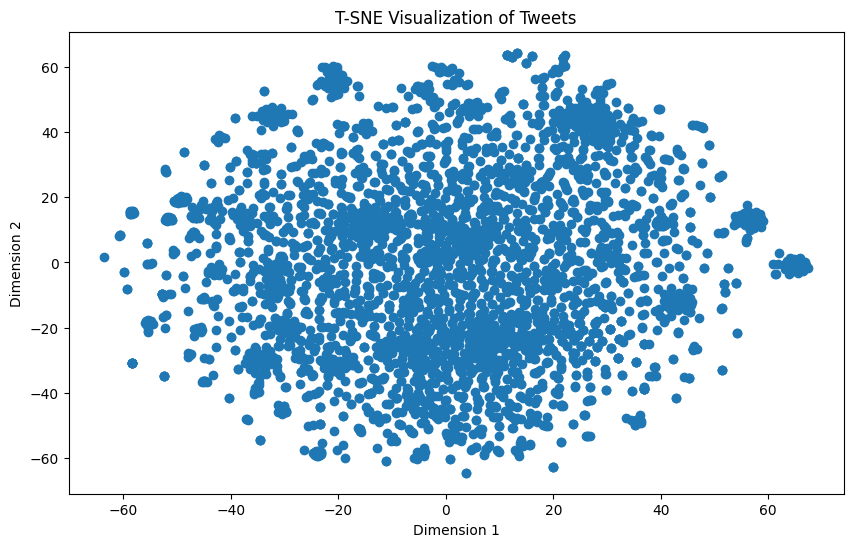

In [ ]:
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt


# Convert your tweet text into TF-IDF vectors
tfidf_vectorizer = TfidfVectorizer()
tfidf_matrix = tfidf_vectorizer.fit_transform(dictionary['ProcessedTweet'])

# Apply T-SNE to reduce dimensionality
tsne = TSNE(n_components=2, random_state=42, init="random")
tsne_result = tsne.fit_transform(tfidf_matrix)

# Create a new DataFrame for the 2D representation
tsne_df = pd.DataFrame(data=tsne_result, columns=['Dimension 1', 'Dimension 2'])

# Plot the 2D scatter plot
plt.figure(figsize=(10, 6))
plt.scatter(tsne_df['Dimension 1'], tsne_df['Dimension 2'])
plt.title("T-SNE Visualization of Tweets")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.show()